 # 1. Install Dependencies and Setup

In [7]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 578.1 MB 8.0 kB/s 
     |████████████████████████████████| 578.1 MB 6.9 kB/s 
     |████████████████████████████████| 511.8 MB 25 kB/s 


In [8]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh                         2.3.3
branca

In [9]:
import tensorflow as tf
import os

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[]

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Remove dodgy images

In [13]:
import cv2
import imghdr

In [14]:
data_dir = '/content/drive/MyDrive/Ds Drive/Colab Notebooks' 

In [15]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [16]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image /content/drive/MyDrive/Ds Drive/Colab Notebooks/mixed/altz
Issue with image /content/drive/MyDrive/Ds Drive/Colab Notebooks/mixed/tum


# 3.LOAD DATA

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 2002 files belonging to 3 classes.


In [19]:
data_iterator = data.as_numpy_iterator()

In [20]:
data_iterator

In [21]:
# get another batch from the iterator
batch = data_iterator.next()

In [22]:
len(batch)

2

In [23]:
# images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [24]:
# CLASS 1 = tumor
# CLASS 0 = alzheimer
batch[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

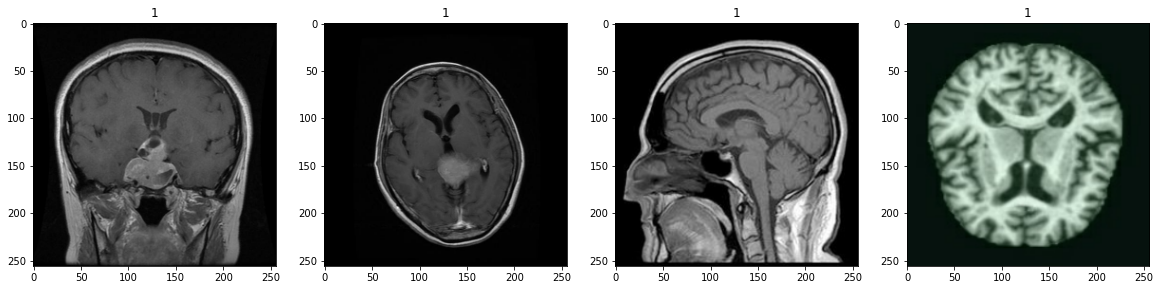

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 3.SCALE DATA

In [26]:
data = data.map(lambda x,y: (x/255, y))

In [27]:
scaled_iterator=data.as_numpy_iterator()

In [28]:
batch = scaled_iterator.next()

In [29]:
batch[0].max()

1.0

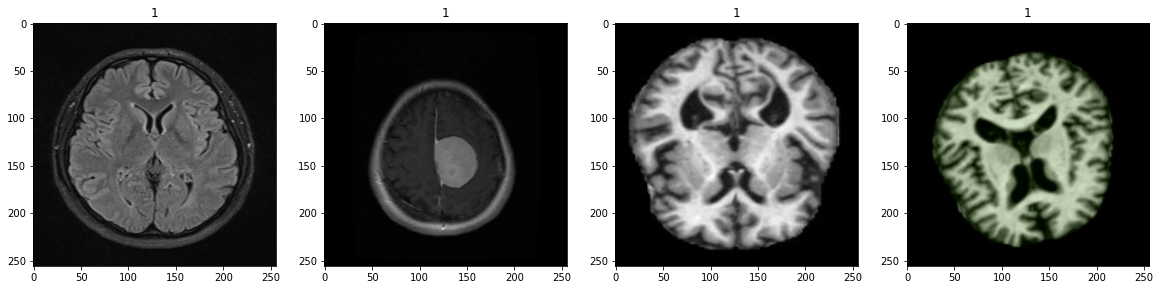

In [30]:
fig , ax = plt.subplots(ncols=4 , figsize=(20,20))
for idx , img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

# 5. SPLIT DATA

BUILD DEEP LEARNING MODEL

In [31]:
len(data)

63

In [32]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [33]:
train_size + val_size + test_size

63

In [34]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. BUILD DEEP LEARNING MODEL

In [35]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [37]:
model = Sequential()

In [38]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

# 7. TRAIN

In [41]:
logdir='logs'

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [43]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3
44/44 [==============================] - 136s 3s/step - loss: -0.1967 - accuracy: 0.9986 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
44/44 [==============================] - 101s 2s/step - loss: -4.0790 - accuracy: 0.9986 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
44/44 [==============================] - 97s 2s/step - loss: -61.9598 - accuracy: 0.9986 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


# 8. PLOT PERFORMANCE

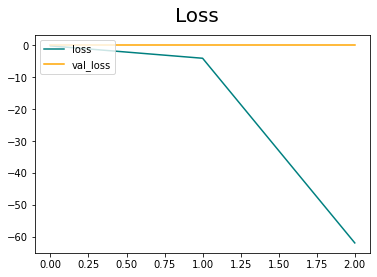

In [44]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

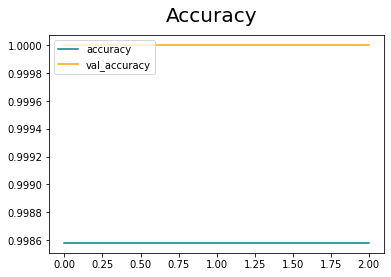

In [45]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. EVALUATION

In [46]:
from tensorflow.python.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [48]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [49]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{re.result().numpy()}')

Precision:1.0,Recall:1.0,Accuracy:1.0


# 10.TEST

In [50]:
import cv2

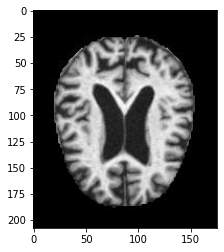

In [53]:
img = cv2.imread('/content/drive/MyDrive/Ds Drive/Colab Notebooks/test/27 (2).jpg')
plt.imshow(img)
plt.show()

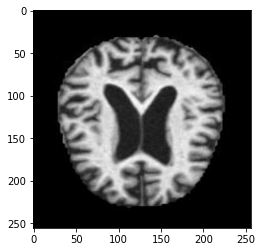

In [54]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [55]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [56]:
yhat

array([[1.]], dtype=float32)

In [57]:
if yhat > 0.5: 
    print(f'Predicted class for the 1st image is Tumor')
else:
    print(f'Predicted class for the 1st image is Alzheimer')

Predicted class for the 1st image is Tumor


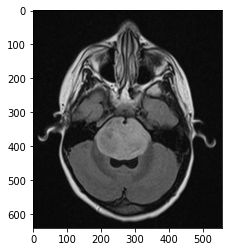

In [59]:
img2 = cv2.imread('/content/drive/MyDrive/Ds Drive/Colab Notebooks/test/image(2).jpg')
plt.imshow(img2)
plt.show()

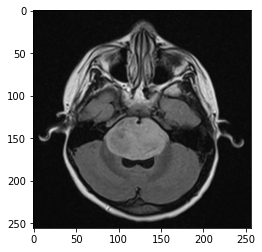

In [60]:
resize = tf.image.resize(img2, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
yhat2 = model.predict(np.expand_dims(resize/255, 0))

In [62]:
yhat2

array([[1.]], dtype=float32)

In [63]:
if yhat2 > 0.5: 
    print(f'Predicted class for the 2nd image is Tumor')
else:
    print(f'Predicted class for the 2nd image is Alzheimer')

Predicted class for the 2nd image is Tumor
